# **02 - Visualization of Results**

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from shapely.geometry import LineString
import os

### 1. Load Data

In [2]:
GEOJSON_PATH = '../2_data/processed/final_dataset.geojson'
SOLUTION_PATH = '../5_results/solutions/solution_optimal.csv'
OUTPUT_DIR_SOL_MAP = '../5_results/solutions'
CSV_PATH = '../2_data/processed/final_dataset.csv'
OUTPUT_DIR_EXP = '../5_results/solutions/species_expansion'

gdf = gpd.read_file(GEOJSON_PATH)
df_sol = pd.read_csv(SOLUTION_PATH)
gdf = gdf.merge(df_sol, on='grid_id', how='left')

### 2. Optimal Solution Map (Combined)
This map visualizes the complete ecological network:
* **Active Cells:** Colored according to the species present (cells shared by multiple species are divided into slices).
* **Corridors:** Represented as dark lines connecting the centers of active cells.

Saved: ../5_results/solutions\optimal_solution_map.png


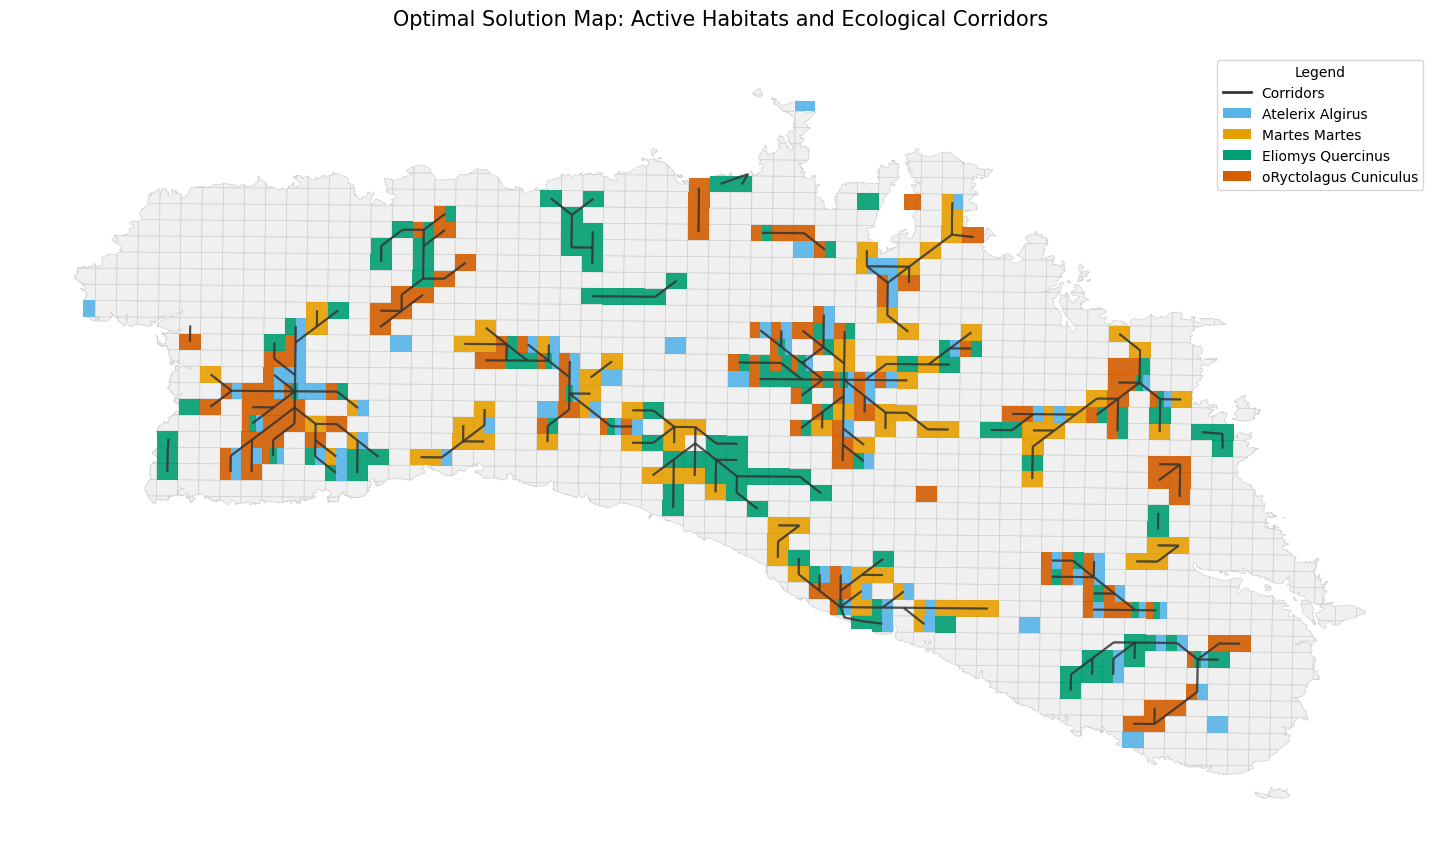

In [3]:
centroids = {}
for idx, row in gdf.iterrows():
    centroids[row['grid_id']] = (row.geometry.centroid.x, row.geometry.centroid.y)

def draw_cell_slices(ax, geom, species_active, colors):
    if not species_active:
        return
    
    minx, miny, maxx, maxy = geom.bounds
    width = maxx - minx
    height = maxy - miny
    n = len(species_active)
    slice_w = width / n
    
    for i, sp in enumerate(species_active):
        # Draw a rectangle for each species sharing the cell
        rect = Rectangle(
            (minx + i * slice_w, miny), slice_w, height,
            facecolor=colors[sp], edgecolor='none', alpha=0.9
        )
        ax.add_patch(rect)

SPECIES_COLORS = {
    'martes': '#E69F00',    
    'oryctolagus': '#D55E00',      
    'eliomys': '#009E73',     
    'atelerix': '#56B4E9'  
}

fig, ax = plt.subplots(figsize=(15, 12))
ax.set_aspect('equal')
ax.set_title("Optimal Solution Map: Active Habitats and Ecological Corridors", fontsize=15, pad=20)

gdf.plot(ax=ax, color='#f0f0f0', edgecolor='#d0d0d0', linewidth=0.5)

corridor_lines = []
for idx, row in gdf.iterrows():
    if pd.notna(row['corridors']):
        neighbors = str(row['corridors']).split(';')
        start_pt = centroids.get(row['grid_id'])
        
        for n_id in neighbors:
            n_id = n_id.strip()
            if n_id in centroids:
                end_pt = centroids[n_id]
                corridor_lines.append(LineString([start_pt, end_pt]))

if corridor_lines:
    gpd.GeoSeries(corridor_lines).plot(ax=ax, color='#333333', linewidth=1.5, alpha=0.6, zorder=2)

# Iterate over the GeoDataFrame to paint each cell according to active species
for idx, row in gdf.iterrows():
    active_species = []
    for sp in SPECIES_COLORS.keys():
        col_name = f'active_{sp}'
        if col_name in row and row[col_name] > 0.5: #
            active_species.append(sp)
    
    if active_species:
        draw_cell_slices(ax, row.geometry, active_species, SPECIES_COLORS)

legend_elements = [
    Line2D([0], [0], color='#333333', lw=2, label='Corridors'),
    Rectangle((0,0), 1, 1, facecolor=SPECIES_COLORS['atelerix'], label='Atelerix Algirus'),
    Rectangle((0,0), 1, 1, facecolor=SPECIES_COLORS['martes'], label='Martes Martes'),
    Rectangle((0,0), 1, 1, facecolor=SPECIES_COLORS['eliomys'], label='Eliomys Quercinus'),
    Rectangle((0,0), 1, 1, facecolor=SPECIES_COLORS['oryctolagus'], label='oRyctolagus Cuniculus'),
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10, title="Legend")

plt.tight_layout()
plt.axis('off') 

output_path = os.path.join(OUTPUT_DIR_SOL_MAP, 'optimal_solution_map.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"Saved: {output_path}")
plt.show()

### 3. Habitat Expansion Analysis (Before vs. After)

This section generates individual comparison maps for each species to visualize the impact of the conservation plan.

For each species, two maps are generated:
1.  **Initial Distribution:** Where the species was present before the optimization.
2.  **Optimized Distribution:** The final result, distinguishing between:
    * **Maintained Habitat:** Original areas that were kept.
    * **New / Restored Habitat:** New areas acquired/restored by the solver (marked with hatched patterns `///`).

Generating expansion maps...


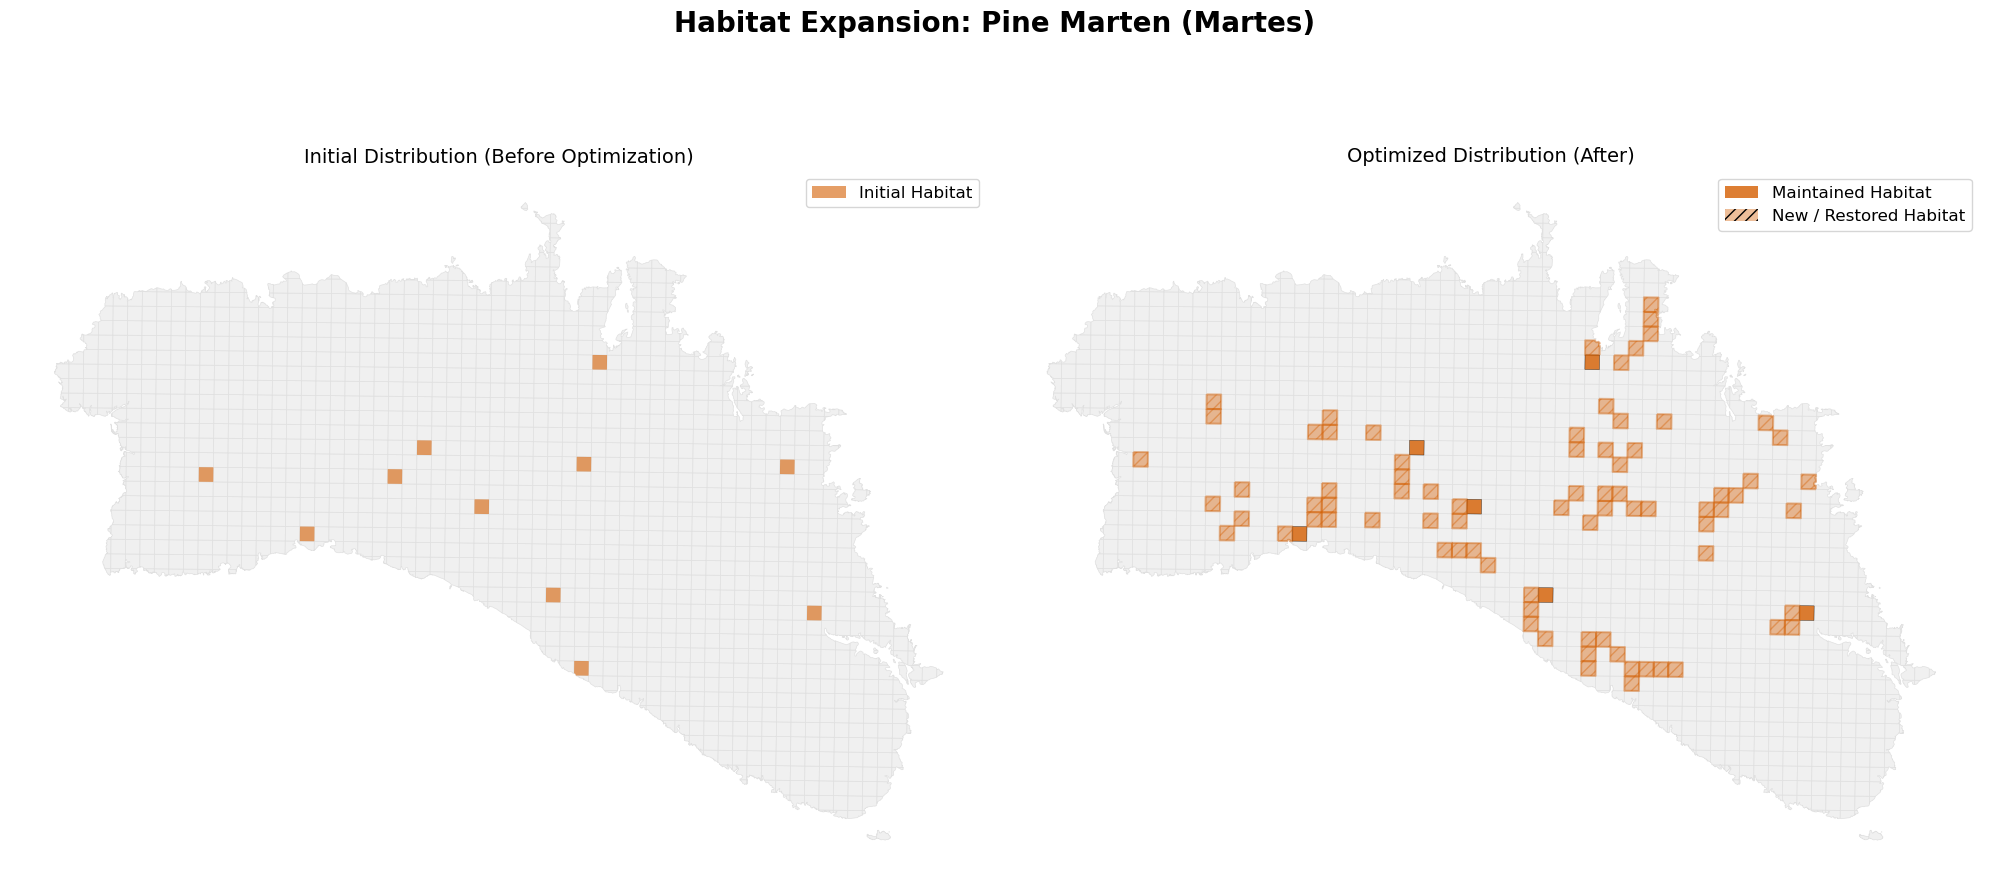

 > Saved: ../5_results/solutions/species_expansion\expansion_martes.png


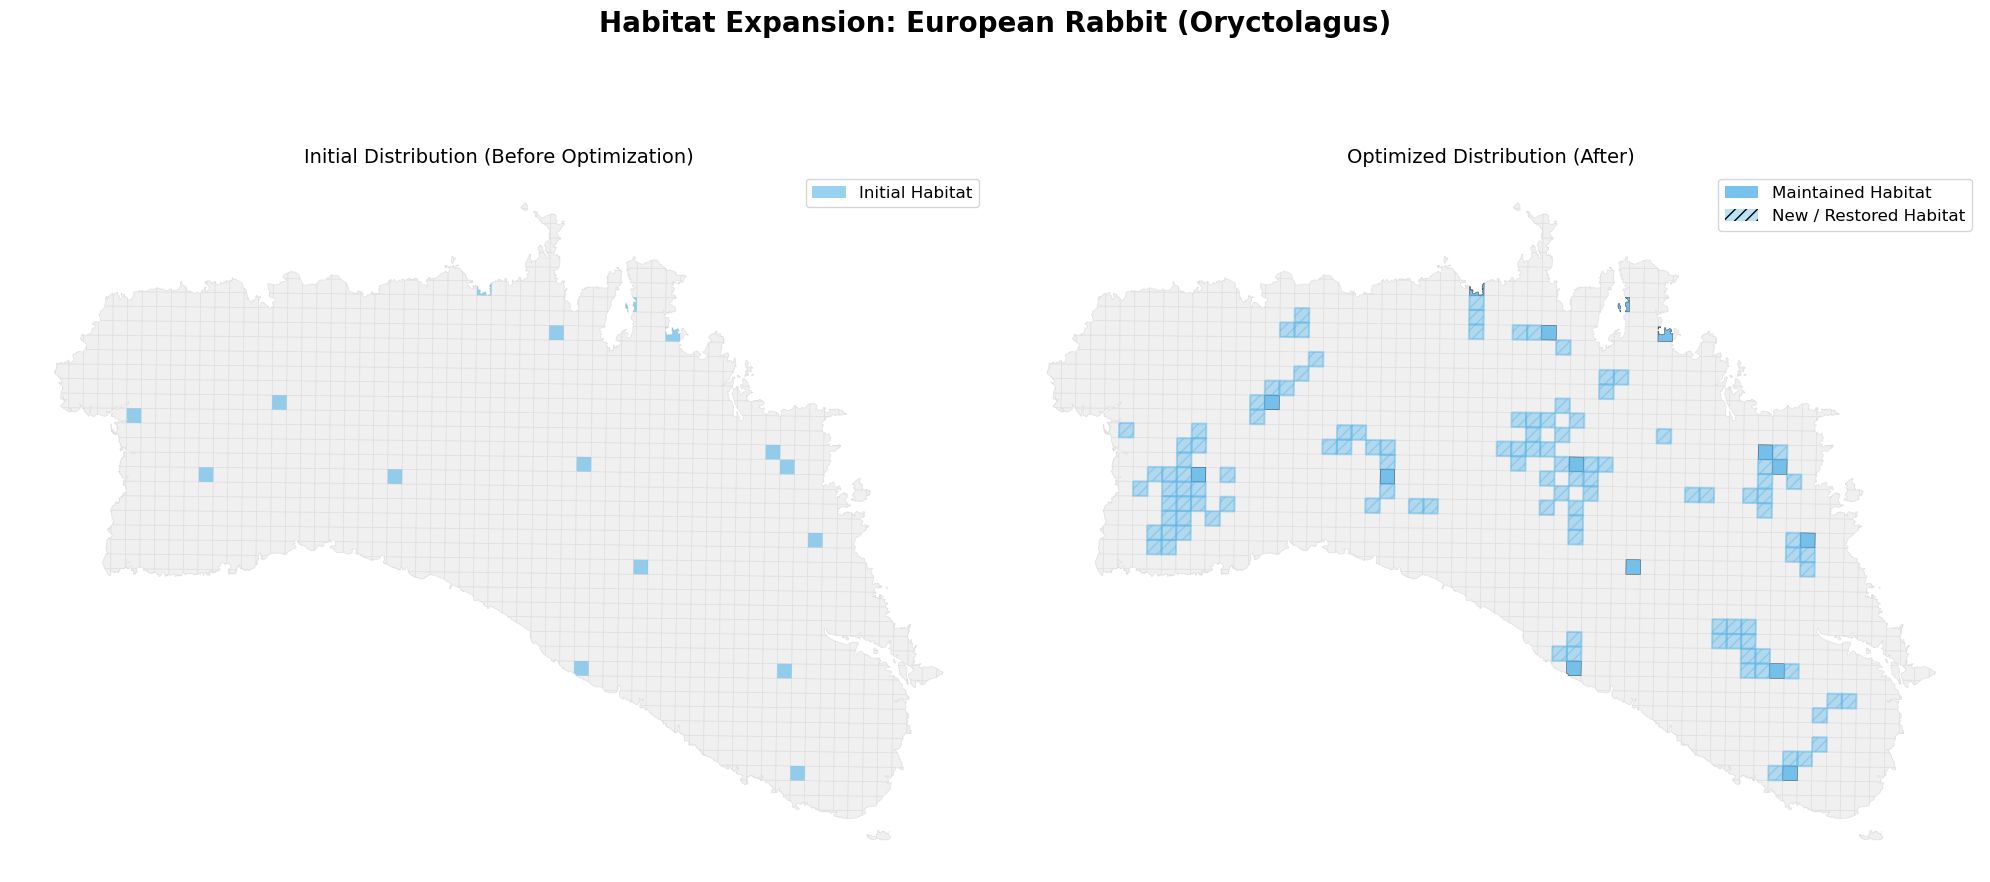

 > Saved: ../5_results/solutions/species_expansion\expansion_oryctolagus.png


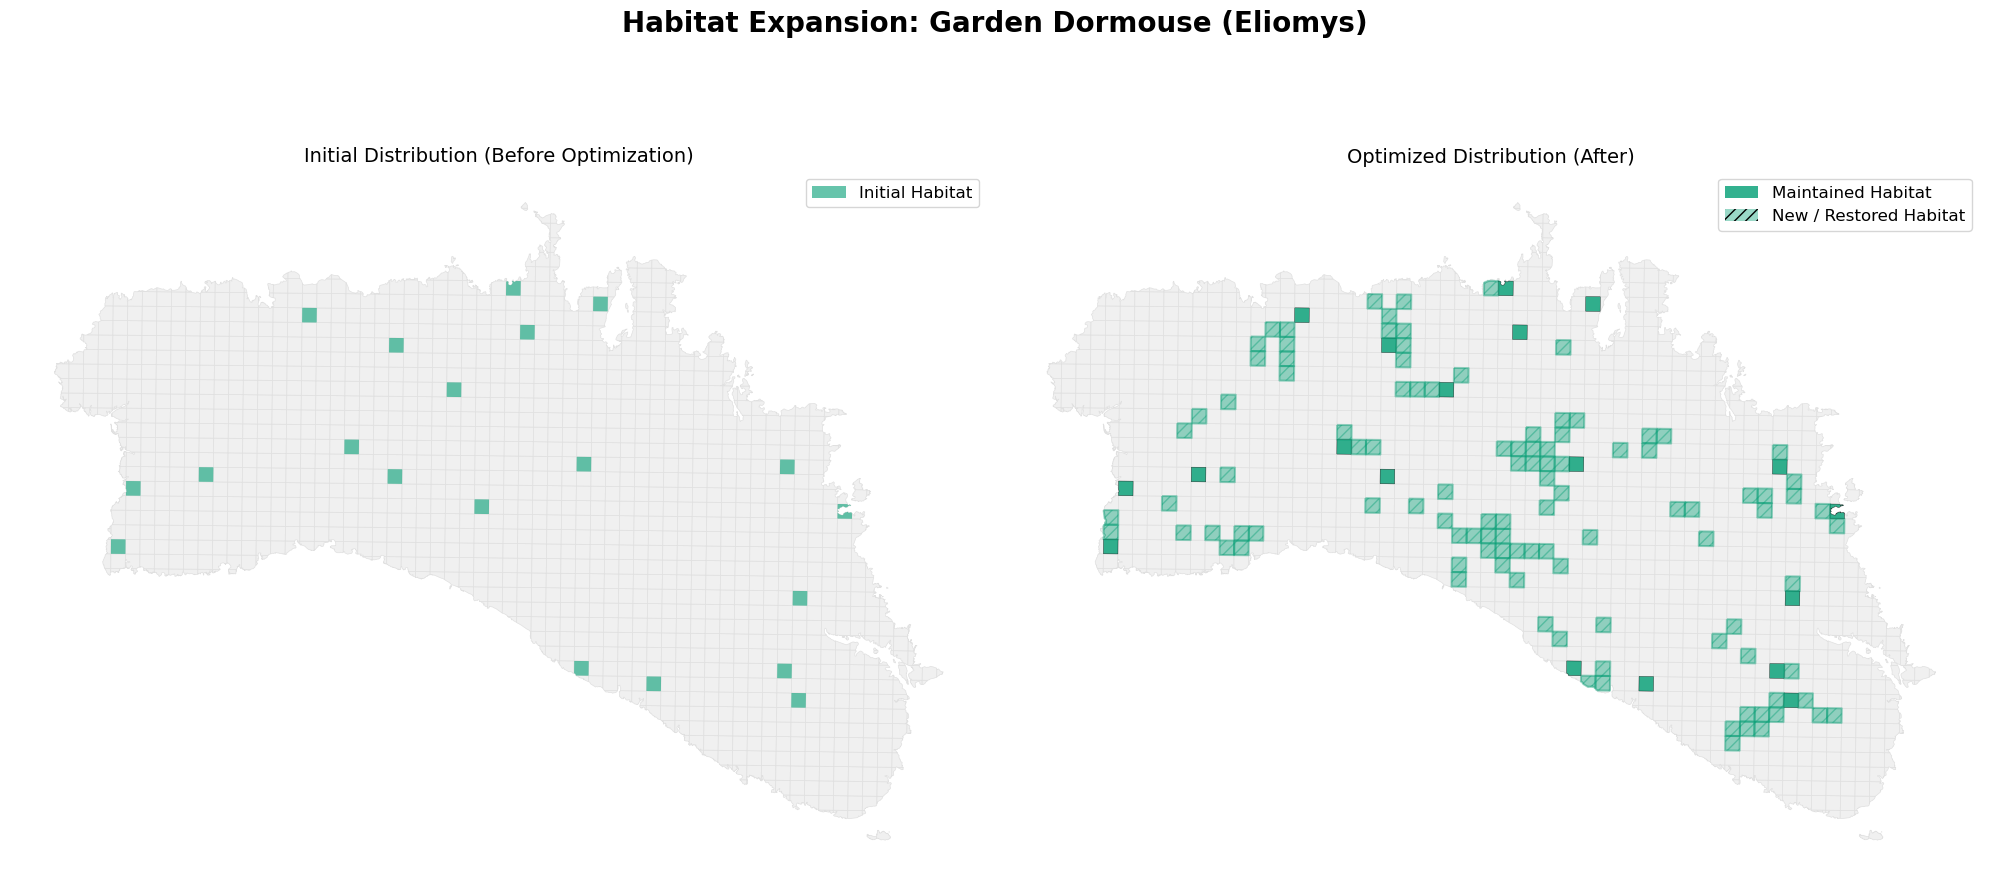

 > Saved: ../5_results/solutions/species_expansion\expansion_eliomys.png


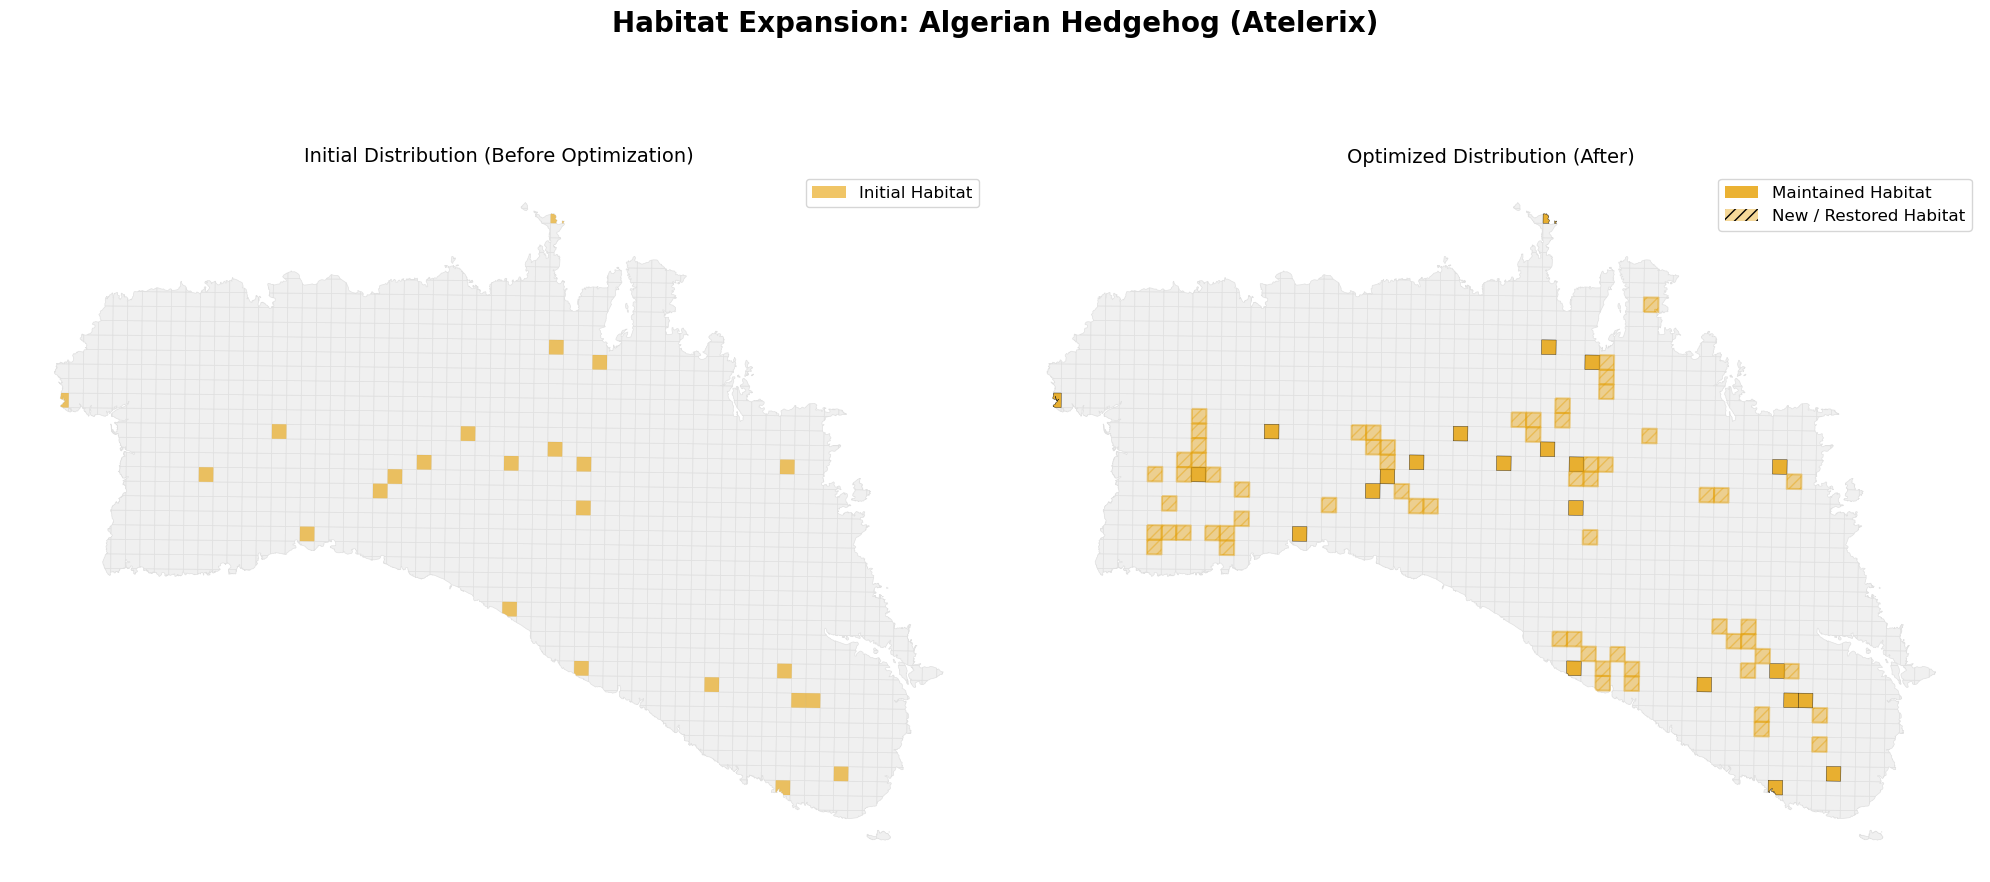

 > Saved: ../5_results/solutions/species_expansion\expansion_atelerix.png

Done! Check '../5_results/solutions/species_expansion'.


In [5]:
SPECIES_CONFIG = {
    'martes': { 'name': 'Pine Marten (Martes)', 'col_initial': 'has_martes_martes', 'color': '#D55E00' },
    'oryctolagus': { 'name': 'European Rabbit (Oryctolagus)', 'col_initial': 'has_oryctolagus_cuniculus', 'color': '#56B4E9' },
    'eliomys': { 'name': 'Garden Dormouse (Eliomys)', 'col_initial': 'has_eliomys_quercinus', 'color': '#009E73' },
    'atelerix': { 'name': 'Algerian Hedgehog (Atelerix)', 'col_initial': 'has_atelerix_algirus', 'color': '#E69F00' }
}

print("Generating expansion maps...")

for sp_code, config in SPECIES_CONFIG.items():
    col_init = config['col_initial']
    col_active = f'active_{sp_code}'
    main_color = config['color']

    if col_init not in gdf.columns:
        print(f"Skipping {sp_code}: Column {col_init} missing.")
        continue

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle(f"Habitat Expansion: {config['name']}", fontsize=20, weight='bold')

    ax1 = axes[0]
    ax1.set_title("Initial Distribution (Before Optimization)", fontsize=14)
    ax1.set_aspect('equal')
    ax1.axis('off')
    gdf.plot(ax=ax1, color='#f0f0f0', edgecolor='#e0e0e0', linewidth=0.5)
    
    initial_habitat = gdf[gdf[col_init] == True]
    if not initial_habitat.empty:
        initial_habitat.plot(ax=ax1, color=main_color, alpha=0.6, edgecolor='none')
    
    legend_1 = [Patch(facecolor=main_color, alpha=0.6, label='Initial Habitat')]
    ax1.legend(handles=legend_1, loc='upper right', fontsize=12)

    ax2 = axes[1]
    ax2.set_title("Optimized Distribution (After)", fontsize=14)
    ax2.set_aspect('equal')
    ax2.axis('off')
    gdf.plot(ax=ax2, color='#f0f0f0', edgecolor='#e0e0e0', linewidth=0.5)
    
    maintained = gdf[(gdf[col_init] == True) & (gdf[col_active] == 1)]
    new_created = gdf[(gdf[col_init] == False) & (gdf[col_active] == 1)]
    
    if not maintained.empty:
        maintained.plot(ax=ax2, color=main_color, alpha=0.8, edgecolor='black', linewidth=0.3)
    if not new_created.empty:
        new_created.plot(ax=ax2, facecolor=main_color, alpha=0.4, 
                         edgecolor=main_color, linewidth=1.5, hatch='///')

    legend_2 = [
        Patch(facecolor=main_color, alpha=0.8, label='Maintained Habitat'),
        Patch(facecolor=main_color, alpha=0.4, hatch='///', label='New / Restored Habitat')
    ]
    ax2.legend(handles=legend_2, loc='upper right', fontsize=12)

    out_path = os.path.join(OUTPUT_DIR_EXP, f'expansion_{sp_code}.png')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    print(f" > Saved: {out_path}")
    plt.close(fig)

print(f"\nDone! Check '{OUTPUT_DIR_EXP}'.")